In [4]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 SUPER


In [2]:
pip install pillow matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------------------------------- - 7.9/8.1 MB 44.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 42.0 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 32.5 MB/s  0:00:00

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   --------------------------------- ------ 5/6 [matplotlib]
   --------------------------------- ------ 5/6 [matplotlib]
   --------------------------------- ------ 5/6 [matplotlib]
   ------------------------------

# Binary image classification (synthetic “surveillance” images): circle (class 0, simulate “person”) vs square (class 1, simulate “vehicle”).

Train/Val/Test sizes: 800/200/200
[Epoch 1] train_loss=0.6900  val_loss=0.6598  val_acc=0.5600
[Epoch 2] train_loss=0.6335  val_loss=0.6518  val_acc=0.6300
[Epoch 3] train_loss=0.6085  val_loss=0.6146  val_acc=0.6250
[Epoch 4] train_loss=0.6040  val_loss=0.6090  val_acc=0.6350
[Epoch 5] train_loss=0.5660  val_loss=0.5931  val_acc=0.6300
[Epoch 6] train_loss=0.5679  val_loss=0.5867  val_acc=0.6500
Saved: ./cv_tinkering\smallcnn_state.pth ./cv_tinkering\smallcnn_traced.pt
Test loss: 0.5713532638549804 Test acc: 0.7


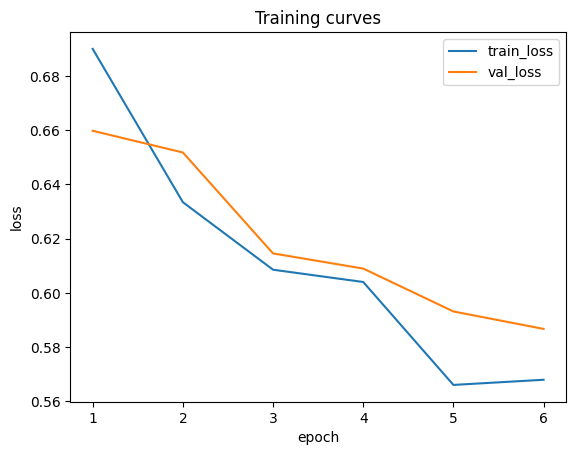

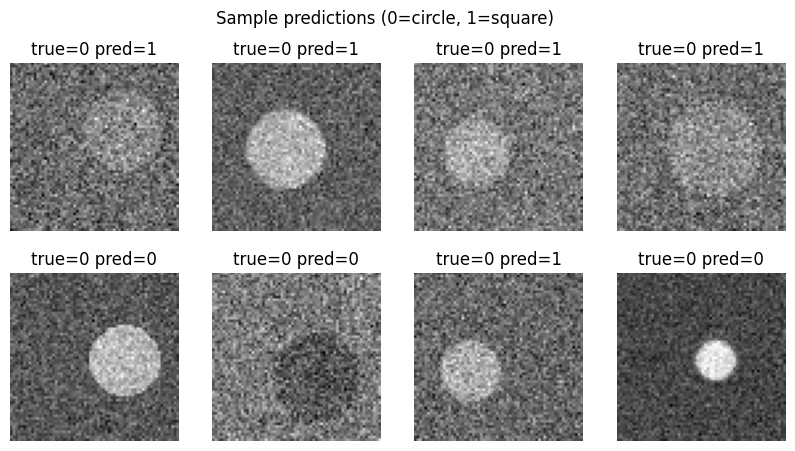

In [3]:
# cv_tinkering.py
# PyTorch computer vision tinkering (synthetic shapes dataset)

import os
import random
from pathlib import Path
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ---------------- Config ---------------- #
BASE_DIR = "./cv_tinkering"
IMG_SIZE = 64
TRAIN_SAMPLES = 800   # total images (split equally between classes)
VAL_SAMPLES = 200
TEST_SAMPLES = 200
BATCH_SIZE = 64
EPOCHS = 6
LR = 1e-3 # learning rate
SEED = 42 # just a random seed number

os.makedirs(BASE_DIR, exist_ok=True)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------------- Synthetic dataset generation ---------------- #
def make_shape_image(shape='circle', size=IMG_SIZE):
    """Create a grayscale image with a circle or a rotated square with noise and blur."""
    bg_color = int(random.uniform(30, 200))
    img = Image.new("L", (size, size), color=bg_color)
    draw = ImageDraw.Draw(img)

    margin = int(size * 0.12)
    min_side = int(size * 0.18)
    max_side = int(size * 0.6)
    w = random.randint(min_side, max_side)
    x0 = random.randint(margin, size - margin - w)
    y0 = random.randint(margin, size - margin - w)
    bbox = [x0, y0, x0 + w, y0 + w]
    shape_color = int(random.uniform(10, 240))

    if shape == 'circle':
        draw.ellipse(bbox, fill=shape_color)
    else:
        square = Image.new("L", (size, size), color=0)
        sq_draw = ImageDraw.Draw(square)
        sq_draw.rectangle(bbox, fill=shape_color)
        angle = random.uniform(-20, 20)
        square = square.rotate(angle, resample=Image.BILINEAR)
        img = Image.composite(square, img, square)

    # optional blur + noise
    if random.random() < 0.45:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0,1.5)))
    arr = np.array(img).astype(np.float32)
    noise = np.random.normal(scale=random.uniform(2,18), size=arr.shape)
    arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def generate_dataset_per_folder(out_dir, n_per_class):
    out_dir = Path(out_dir)
    for cls in ['circle','square']:
        d = out_dir / cls
        d.mkdir(parents=True, exist_ok=True)
        for i in range(n_per_class):
            img = make_shape_image(shape=cls, size=IMG_SIZE)
            img.save(d / f"{cls}_{i:04d}.png")

# Create data if not exist
train_dir = Path(BASE_DIR) / "train"
val_dir   = Path(BASE_DIR) / "val"
test_dir  = Path(BASE_DIR) / "test"
if not any(train_dir.rglob("*.png")):
    generate_dataset_per_folder(train_dir, TRAIN_SAMPLES//2)
if not any(val_dir.rglob("*.png")):
    generate_dataset_per_folder(val_dir, VAL_SAMPLES//2)
if not any(test_dir.rglob("*.png")):
    generate_dataset_per_folder(test_dir, TEST_SAMPLES//2)

# ---------------- PyTorch Dataset (no torchvision required) ----------------
class ShapesDataset(Dataset):
    def __init__(self, root_dir, img_size=IMG_SIZE):
        self.files = sorted(list(Path(root_dir).rglob("*.png")))
        self.img_size = img_size
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        p = self.files[idx]
        img = Image.open(p).convert("L")
        if img.size != (self.img_size, self.img_size):
            img = img.resize((self.img_size, self.img_size), resample=Image.BILINEAR)
        arr = np.array(img).astype(np.float32) / 255.0        # [0,1]
        arr = (arr - 0.5) / 0.5                              # normalize to roughly [-1,1]
        tensor = torch.from_numpy(arr).unsqueeze(0).float()  # [1,H,W]
        label = 0 if "circle" in p.name else 1
        return tensor, label

train_ds = ShapesDataset(train_dir)
val_ds = ShapesDataset(val_dir)
test_ds = ShapesDataset(test_dir)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

# ---------------- Small CNN model ----------------
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*(IMG_SIZE//8)*(IMG_SIZE//8), 128), nn.ReLU(),
            nn.Linear(128, 2)
        )
    def forward(self,x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# ---------------- Train / Evaluate ----------------
def evaluate(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            loss_sum += loss.item() * xb.size(0)
            correct += (out.argmax(dim=1) == yb).sum().item()
            total += xb.size(0)
    return loss_sum / total, correct / total

train_losses, val_losses, val_accs = [], [], []
for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    train_loss = running / len(train_loader.dataset)
    val_loss, val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss); val_losses.append(val_loss); val_accs.append(val_acc)
    print(f"[Epoch {epoch}] train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

# ---------------- Save model checkpoints and TorchScript ----------------
weights_path = os.path.join(BASE_DIR, "smallcnn_state.pth")
torch.save(model.state_dict(), weights_path)

example_input = torch.randn(1,1,IMG_SIZE,IMG_SIZE).to(device)
traced = torch.jit.trace(model, example_input)
traced_path = os.path.join(BASE_DIR, "smallcnn_traced.pt")
traced.save(traced_path)
print("Saved:", weights_path, traced_path)

# ---------------- Final test evaluation and sample prediction plot ----------------
test_loss, test_acc = evaluate(model, test_loader)
print("Test loss:", test_loss, "Test acc:", test_acc)

# Plot simple train/val loss (requires matplotlib)
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses, label="train_loss")
plt.plot(range(1, EPOCHS+1), val_losses, label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.title("Training curves")
plt.show()

# Show 8 sample predictions
model.eval()
samples, labels, preds = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb.to(device))
        p = out.argmax(dim=1).cpu().numpy()
        samples.extend(xb.numpy()); labels.extend(yb.numpy()); preds.extend(p)
        if len(samples) >= 8:
            break

fig, axs = plt.subplots(2,4, figsize=(10,5))
axs = axs.flatten()
for i in range(8):
    axs[i].imshow(samples[i].squeeze(0), cmap='gray'); axs[i].axis('off')
    axs[i].set_title(f"true={labels[i]} pred={int(preds[i])}")
plt.suptitle("Sample predictions (0=circle, 1=square)"); plt.show()
